# Calibration channels vs. $2 \theta$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit

import os
 
# change the current directory
# to specified directory
os.chdir(r"/home/simo/Scrivania/Thesis/7C2_Analysis/Raw_data")

In [2]:
def get_indices_in_range(lst, start, end):
    """
    Returns a new list containing only the indices of the values within the given range (inclusive).
    """
    return [i for i, x in enumerate(lst) if start <= x <= end]

def remove_indexes(my_list, indexes_to_remove):
    return [x for i, x in enumerate(my_list) if i not in indexes_to_remove]

def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)

    return col

def gaussian(x, a, x0, sigma):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2))


def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y

def my_round(x,dx):      # per avere dato + errore con le giuste cire significative (incertezza con una sola cifra significativa)  ---> da sistemare,quando dx salta di cifra x resta arrotondato a cifra sotto
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            if dx[i] < 1:
                dist = -int(np.log10(dx[i])-1)
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx[i]))
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)))
            round_x.append([x_new,dx_new])
    else:
            if dx < 1:
                dist = -int(np.log10(dx)-1)
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx))
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)))
            round_x.append([x_new, dx_new])
    return round_x

# Detector parameters

channels = read_dat_file('efficiency',3)[0] # canali del detector
angle_range = 128   # range angolare del detector
angle = channels
q = channels

In [3]:
# function to plot data

def plot_raw_data(file0,num_files, title,x_axis):
    efficiency = read_dat_file('efficiency',3)[1]
    filename = []

    for i in range (num_files):
        num = int(file0) + i
        num = str(num)
        filename.append('bs'+num)

    data = []
    err_data = []

    for i in range (num_files):
        name = filename[i]
        data.append(read_dat_file(name,3)[1]/efficiency)
        err_data.append(read_dat_file(name,3)[2]/efficiency)
        if x_axis == 'channel':
            plt.errorbar(channels,data[i], fmt = '-', yerr = err_data[i] ,label = name)
            plt.xlabel('Channel')
        elif x_axis == 'theta':
            plt.errorbar(angle,data[i], fmt = '-', yerr = err_data[i] ,label = name)
            plt.xlabel(r'$2 \theta$ [$^{\circ}$]') 
        elif x_axis == 'q':
            plt.errorbar(q,data[i], fmt = '-', yerr = err_data[i] ,label = name)
            plt.xlabel(r'Exchanged wavevector $q$ [$\AA^{-1}$]')
        else:
            print('Invalid scale for x-axis')
            break
    plt.ylabel('Intensity  [counts]')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()
    return data, err_data


# Efficiency

efficiency    

Efficiency of channels: divide by it to smooth data

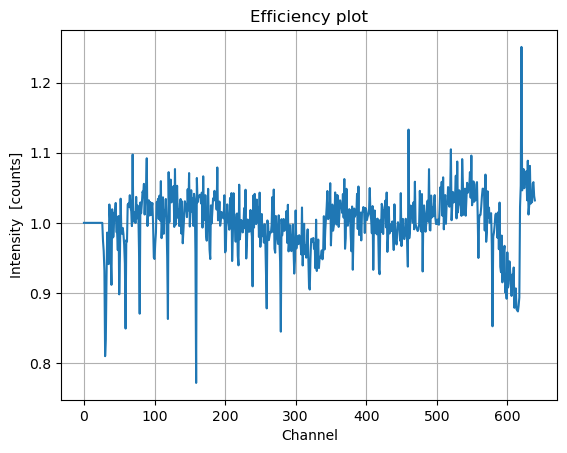

In [4]:
efficiency = read_dat_file('efficiency',3)[1]
err_efficiency = read_dat_file('efficiency',3)[2]
plt.plot(channels,efficiency, '-')
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Efficiency plot')
plt.grid()
plt.show()

# NICKEL POWDER : Calibration $2 \theta$ vs. channel

Use Ni reflections to calibrate the scattering angle in function of the channel. To gain resolution and fit better the peaks 4 repetitions were done and in each one the detector was rotated 1/4 of step, in order to increase the number of data.  

bs44380	M=200000   
bs44381	M=200000 con detector ruotato di 0.05°  
bs44382	M=200000 con detector ruotato di 0.10°  
bs44383	M=200000 con detector ruotato di 0.14° 

In order to calibrate one fits the full profile, in arbitrary units, to the following function

$$
I(2 \theta) = I_B(2 \theta) + I_T(2 \theta) + bkg
$$

with $2 \theta$ the scattering angle, $I_B(2 \theta)$ the Bragg peaks intensity, $I_T(2 \theta) = A S_T(2 \theta)$ the Thermal Diffuse Scattering (TDS) intensity, and $bkg$ a constant background from incoherent scattering. The scattering angle is written as $2 \theta = 2 \theta_0 + \Delta \theta channel $, with $2 \theta_0$ a fitting parameter and $\Delta \theta$ is known to be $0.2^{\circ}$, since there are 640 channels covering an angular range of $128^{\circ}$. $I_B(2 \theta)$ is written as a sum of gaussians centered around the Bragg peaks and with width given by the instrumental resolution. The peaks position is computed according to Bragg law

$$
\lambda = 2 d_{hkl}\sin(\theta)  \qquad 2\theta = 2 \arcsin\left(\frac{\lambda}{2 d_{hkl}}\right)
$$

with $\lambda$ the neutron wavelength selected at the monocromator, which is left as a fit parameter, $d_{hkl}$ the d-spacing of planes (hkl) and $\theta$ is half the scattering angle, or the Bragg angle. One finds the allowed reflections for the Ni powder (hkl), associate them with the observed peaks in the pattern and retrieves the corresponding d-spacing $d_{hkl}$ as 
$$
\frac{1}{d_{hkl}} = \frac{\sqrt{h^2+k^2+l^2}}{a}
$$

with $a = 3.524 \AA$ the lattice parameter at 293 K (from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K").  
The width of the peaks is fixed by the relation in "Caglioti et al. CHOICE OF COLLIMATORS FOR A CRYSTAL SPECTROMETER FOR NEUTRON DIFFRACTION"
$$
FWHM(2 \theta) = \sqrt{W_0 + W_1 \tan(\theta)+ W_2 \tan(\theta)^2} \qquad \sigma = FWHM/\left(2\sqrt(2 \log(2))\right)
$$

with $W_0$, $W_1$ and $W_2$, as fitting parameters. From VESTA onme retrieves 34 diffraction peaks in the angular range covered, their height is left as a fitting parameter, giving as p0 in curve_fit the intensity computed by VESTA (opportunely rescaled to conisder the differences between observed pattern and theoretical one).  
Finally the background is composed by the sum of a constant baseline $bkg$ coming from incoherent scattering, which is a fitting parameter, and TDS. The factor $A$ multiplying the TDS accounts for the incorrect normalization of the data and is left as a fitting parameter. Then the TDS is written as
$$
S_T(2 \theta) = 1- e^{-2 B \left(\sin \theta/\lambda\right)^2}
$$
with $2 B = 0.3559 \AA^2$ from "Debye–Waller Factors and Absorptive Scattering Factors of Elemental Crystals, Lianmao Peng, G. Ren, M. Whelan".

Then one has a fitting function with 41 free parameters, given by the 34 peaks height, $\lambda$, $\theta_0$, $W_0$, $W_1$, $W_2$, $bkg$ and $A$.  
The data are not treated accordingly to Petrillo and Sacchetti as no ancillary measurements were taken. The sample is composed by pressed powder with no cell and the measurements were carried at room temperature.



Import data of four repetitions

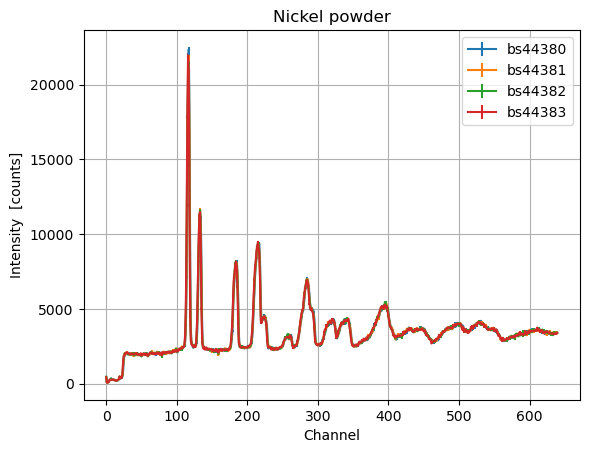

In [5]:
nickelone, err_nickelone = plot_raw_data('44380',4, 'Nickel powder','channel')


Merge the four set of data by considering fractions of channel

In [6]:
step = np.zeros(4*np.size(channels))
nickel= np.zeros(4*np.size(channels))
err_nickel = np.zeros(4*np.size(channels))


for i in range(np.size(channels)):
    step[4*i] = i 
    step[4*i+1] = i + 0.25
    step[4*i+2] = i + 0.5
    step[4*i+3] = i + 0.14/0.2

    nickel[4*i] = nickelone[0][i]
    nickel[4*i+1] = nickelone[1][i]
    nickel[4*i+2] = nickelone[2][i]
    nickel[4*i+3] = nickelone[3][i]

    err_nickel[4*i] = err_nickelone[0][i]
    err_nickel[4*i+1] = err_nickelone[1][i]
    err_nickel[4*i+2] = err_nickelone[2][i]
    err_nickel[4*i+3] = err_nickelone[3][i]

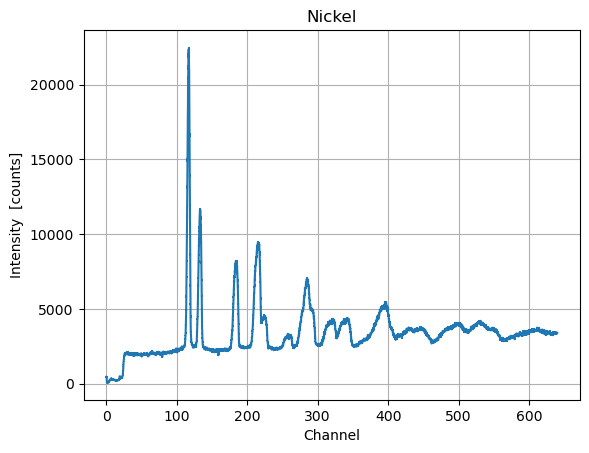

In [7]:
#%matplotlib ipympl
plt.errorbar(step,nickel, fmt = '-', yerr = err_nickel)
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.grid()
plt.show()

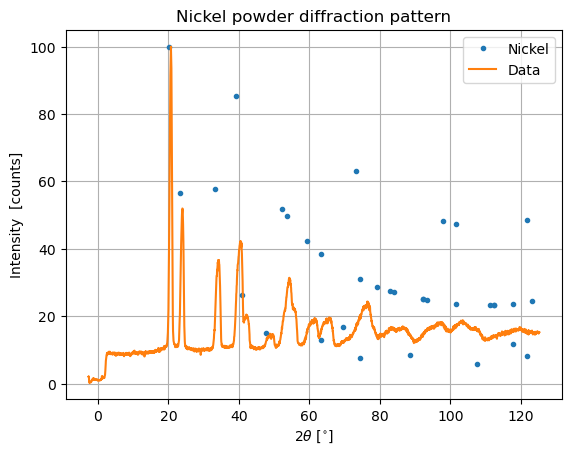

In [8]:
#Compare with diffraction pattern from VESTA
#%matplotlib ipympl
twotheta = read_dat_file('nickel_vesta',1)[7]
intensity = read_dat_file('nickel_vesta',1)[8]

plt.plot(twotheta,intensity,'.',label = 'Nickel')
plt.plot(0.2*step-2.68,nickel*100/max(nickel),label = 'Data') #assume a certain theta_0 value
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel powder diffraction pattern')
plt.legend()
plt.grid()
plt.show()

Define allowed $d_{hkl}$, theoretical peaks intensities and normalize data to $\%$

In [9]:
B = 0.3559/2 # Angstrom^2  Debye-waller factor of Ni at 293 K

# lattice parameter
a = 3.524 # Angstrom   at 293 K from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K"
h = read_dat_file('nickel_vesta',1)[0]
k = read_dat_file('nickel_vesta',1)[1]
l = read_dat_file('nickel_vesta',1)[2]
d_inverso = np.sqrt(h**2+k**2+l**2)/a

intensity = read_dat_file('nickel_vesta',1)[8]*np.array([1,0.8,0.5,0.4,0.5,0.5,0.4,0.4,0.25,0.25,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]) #need to correct them to match better the data

nickel_norm= 100*nickel/max(nickel)
err_nickel_norm = 100*np.sqrt(err_nickel**2 + max(nickel))/max(nickel)

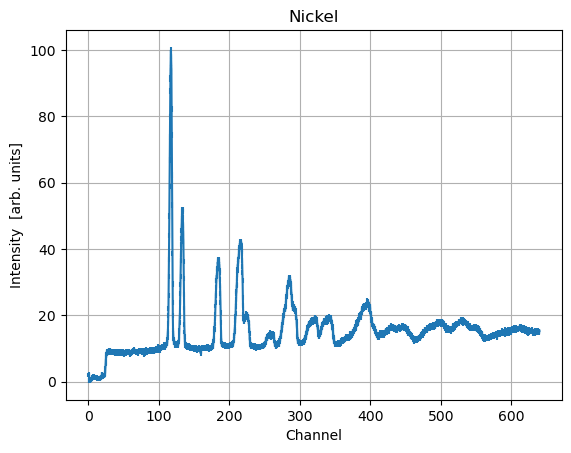

In [10]:
#%matplotlib ipympl
plt.errorbar(step,nickel_norm, fmt = '-', yerr = err_nickel_norm)
plt.xlabel('Channel')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()

Fitting function

In [11]:
def tds(x, lamda):  # give twotheta in input in deg
    return 1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)

def fit_full_profile(x,lamda,theta0,w0,w1,w2, bkg, a,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25,I26,I27,I28,I29,I30,I31,I32,I33):

    intensita = [I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25,I26,I27,I28,I29,I30,I31,I32,I33]
    d_theta = 0.2
    twotheta = (theta0+d_theta*x)

    tds =  1- np.exp(-2*B*(np.sin(twotheta*np.pi/360)/lamda)**2)

    peaks = np.arcsin(lamda*d_inverso/2)*360/np.pi
    widths = np.sqrt(w0+w1*np.tan(peaks*np.pi/360)+w2*np.tan(peaks*np.pi/360)**2)/(2*np.sqrt(2*np.log(2)))

    par = []

    for i in range(len(d_inverso)):
        par.append(intensita[i])
        par.append(peaks[i])
        par.append(widths[i])

    funz = bkg + a*tds + gaussian_sum(twotheta, *par)

    return funz

 #### Fit to full profile ####
lambda 0.7299 +/- 0.0002 Angstrom
theta0 -2.683 +/- 0.006 deg
W0 0.16 +/- 0.1 deg^2
W1 -2.7 +/- 0.9 deg^2
W2 27.0 +/- 2.0 deg^2
bkg 9.51 +/- 0.05 counts
A 8.5 +/- 0.8 counts
Intensity peak  0 91.2 +/- 0.4 counts
Intensity peak  1 43.3 +/- 0.3 counts
Intensity peak  2 27.4 +/- 0.3 counts
Intensity peak  3 32.6 +/- 0.2 counts
Intensity peak  4 8.4 +/- 0.2 counts
Intensity peak  5 4.1 +/- 0.2 counts
Intensity peak  6 13.4 +/- 0.2 counts
Intensity peak  7 10.7 +/- 0.2 counts
Intensity peak  8 8.6 +/- 0.2 counts
Intensity peak  9 0.0 +/- 800000.0 counts
Intensity peak  10 0.0 +/- 800000.0 counts
Intensity peak  11 2.5 +/- 0.2 counts
Intensity peak  12 8.9 +/- 0.3 counts
Intensity peak  13 0.0 +/- 700000.0 counts
Intensity peak  14 0.0 +/- 700000.0 counts
Intensity peak  15 3.0 +/- 0.2 counts
Intensity peak  16 2.8 +/- 0.4 counts
Intensity peak  17 2.0 +/- 0.4 counts
Intensity peak  18 0.3 +/- 0.2 counts
Intensity peak  19 0.0 +/- 1000000.0 counts
Intensity pea

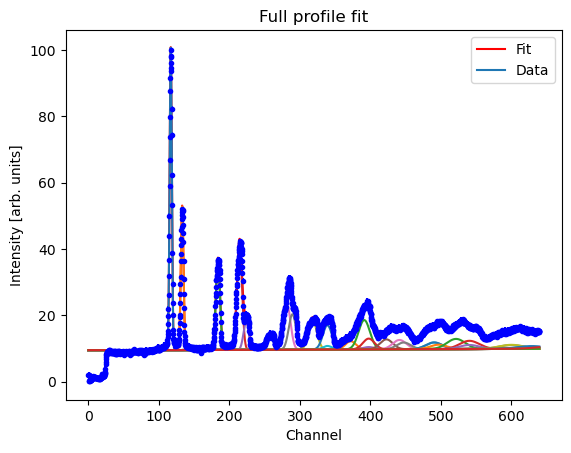

In [12]:
#%matplotlib ipympl
index = get_indices_in_range(step,27,639)#,350) # do not consider first step form direct beam

#print(intensity)

#parameters to fit just the first 10 peaks
#p0 = [0.729,-3,1.2,-12,45,2000,2640,intensity[0],intensity[1],intensity[2],intensity[3],intensity[4],intensity[5],intensity[6],intensity[7],intensity[8],intensity[9]]
#bounds= [[0.7,-15,0,-1000,0,0,0, 0,0,0,0,0,0,0,0,0,0],[0.8,-2,100,100, 105,3000,5000, 1.5*intensity[0],1.5*intensity[1],1.5*intensity[2],1.5*intensity[3],1.5*intensity[4],1.5*intensity[5],1.5*intensity[6],1.5*intensity[7],1.5*intensity[8],1.5*intensity[9]]]

p0 = np.array([0.729,-3,1.2,-12,45,10,10])
p0 = np.append(p0,intensity)


bounds= [[0.7,-15,0,-1000,0,0,0, 0,0,0,0,0,0,0,0,0,0,  0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0 ,0,0,0,0],[0.8,-2,100,100, 105,3000,5000, 1.5*intensity[0],1.5*intensity[1],1.5*intensity[2],1.5*intensity[3],1.5*intensity[4],1.5*intensity[5],1.5*intensity[6],1.5*intensity[7],1.5*intensity[8],1.5*intensity[9], 1.5*intensity[10],1.5*intensity[11],1.5*intensity[12],1.5*intensity[13],1.5*intensity[14],1.5*intensity[15],1.5*intensity[16],1.5*intensity[17],1.5*intensity[18],1.5*intensity[19], 1.5*intensity[20],1.5*intensity[21],1.5*intensity[22],1.5*intensity[23],1.5*intensity[24],1.5*intensity[25],1.5*intensity[26],1.5*intensity[27],1.5*intensity[28],1.5*intensity[29], 1.5*intensity[30],1.5*intensity[31],1.5*intensity[32],1.5*intensity[33]]]

popt, pcov = curve_fit(fit_full_profile, step[index], nickel_norm[index], sigma= err_nickel_norm[index], p0=p0,bounds = bounds, maxfev = 80000)

chi_sq = sum((fit_full_profile(step[index],*popt)-nickel_norm[index])**2/err_nickel_norm[index]**2)/(len(nickel_norm[index])-(7+len(intensity)))

lamda = popt[0]
err_lamda = np.sqrt(pcov[0][0])

theta0 = popt[1]
err_theta0 = np.sqrt(pcov[1][1])

W0 = popt[2]
err_W0 = np.sqrt(pcov[2][2])

W1 = popt[3]
err_W1 = np.sqrt(pcov[3][3])

W2 = popt[4]
err_W2 = np.sqrt(pcov[4][4])

peaks = np.arcsin(lamda*d_inverso/2)*360/np.pi
widths = np.sqrt(W0+W1*np.tan(peaks*np.pi/360)+W2*np.tan(peaks*np.pi/360)**2)/(2*np.sqrt(2*np.log(2)))

print(' #### Fit to full profile ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))
#print(popt,np.sqrt(np.diag(pcov)))
gaussian_parameters = []

print('lambda',par[0][0], '+/-', par[0][1],'Angstrom')
print('theta0',par[1][0], '+/-', par[1][1],'deg')
print('W0',par[2][0], '+/-', par[2][1],'deg^2')
print('W1',par[3][0], '+/-', par[3][1],'deg^2')
print('W2',par[4][0], '+/-', par[4][1],'deg^2')
print('bkg',par[5][0], '+/-', par[5][1],'counts')
print('A',par[6][0], '+/-', par[6][1],'counts')
for i in range (len(intensity)):
    print('Intensity peak ',i ,par[7+i][0], '+/-', par[7+i][1],'counts')
    gaussian_parameters.append(popt[7+i])
    gaussian_parameters.append(peaks[i])
    gaussian_parameters.append(widths[i])

print('Chi squared/ dof',chi_sq)


x_plot = np.linspace(min(step), max(step),10000)
plt.plot(x_plot, fit_full_profile(x_plot, *popt),color='red')
plt.errorbar(step,nickel_norm, yerr=err_nickel_norm, fmt='.',color='blue')
for i in range(len(intensity)):
    plt.plot(x_plot,gaussian(x_plot*0.2+theta0,*gaussian_parameters[3*i : 3*i+3])+popt[5]+tds(theta0+0.2*x_plot,lamda))
plt.title('Full profile fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'Intensity [arb. units]')
plt.xlabel('Channel')
plt.show()

Observe Caglioti trend of $FWHM$

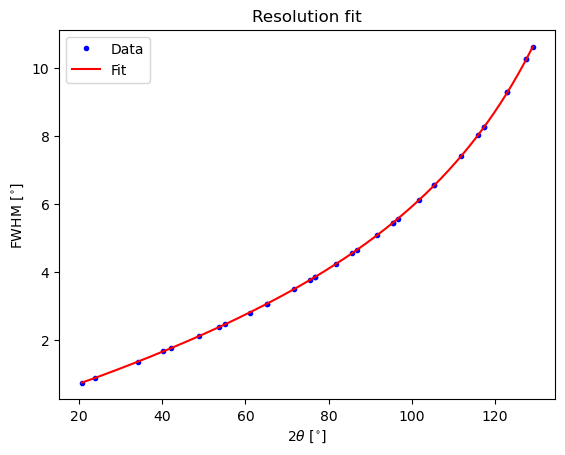

In [13]:
x_plot =  np.linspace(min(peaks), max(peaks),10000)

fit = np.sqrt(W0+W1*np.tan(x_plot*np.pi/360)+W2*np.tan(x_plot*np.pi/360)**2)

plt.plot(peaks, 2*np.sqrt(2*np.log(2))*widths,'.',color='blue')
plt.plot(x_plot,fit,color='red')
plt.title('Resolution fit')
plt.legend([ 'Data','Fit'])
plt.ylabel(r'FWHM [$^{\circ}$]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()

Define calibration curves

In [14]:
def steps_to_angle(x):
    x = np.array(x)
    return theta0 + 0.2*x, err_theta0

def steps_to_q(x):
    angle = theta0 + 0.2*x
    q = 4*np.pi*np.sin(angle*np.pi/360)/lamda   # in Angstrom inversi
    err_q = abs(q)*np.sqrt((err_lamda/lamda)**2+(err_theta0*np.pi/360/np.tan(angle*np.pi/360))**2)
    return q, err_q

#Define scattering angle 2theta and exchanged wavewector q
angle, err_angle = steps_to_angle(channels)
q, err_q = steps_to_q(channels)

print('Minimum distance that can be proved:',2*np.pi/max(q),'Å')

Minimum distance that can be proved: 0.4112403475916939 Å


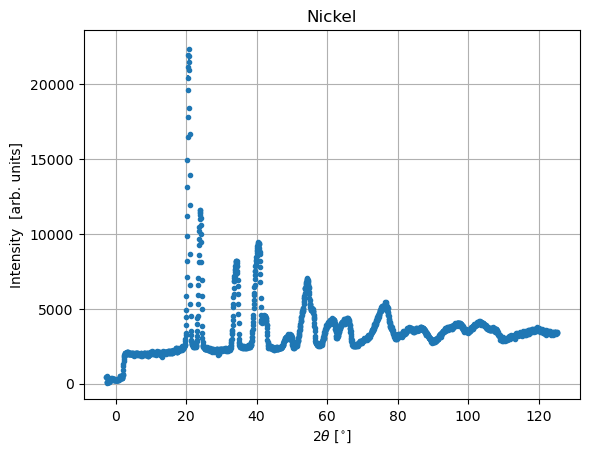

In [15]:
#%matplotlib ipympl
plt.errorbar(steps_to_angle(step)[0],nickel, fmt = '.', yerr = err_nickel, xerr= steps_to_angle(step)[1])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()

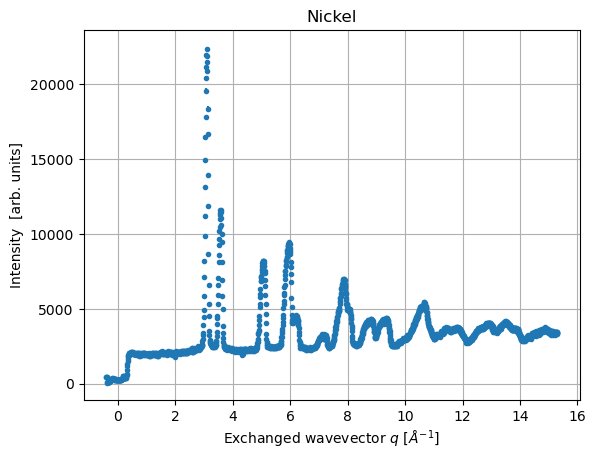

In [16]:
#%matplotlib ipympl
plt.errorbar(steps_to_q(step)[0],nickel, fmt = '.', yerr = err_nickel, xerr= steps_to_q(step)[1])
plt.xlabel(r'Exchanged wavevector $q$ [$\AA^{-1}$]')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()

Save the calibration results on a file

In [19]:
with open('calibration.dat', 'w', encoding='utf-8') as f:
    f.write('angle err_angle q err_q \n')
    for i in range(np.size(angle)):
        f.write(str(angle[i]))
        f.write(' ') 
        f.write(str(err_angle))
        f.write(' ')
        f.write(str(q[i]))
        f.write(' ')
        f.write(str(err_q[i]))
        f.write('\n')
    f.close()

with open('calibration_parameters.dat', 'w', encoding='utf-8') as f:
    f.write('theta0 err_theta0 lambda err_lambda w0 err_w0 w1 err_w1 w2 err_w2\n')
    f.write(str(theta0))
    f.write(' ') 
    f.write(str(err_theta0))
    f.write(' ')
    f.write(str(lamda))
    f.write(' ')
    f.write(str(err_lamda))
    f.write(' ') 
    f.write(str(W0))
    f.write(' ') 
    f.write(str(err_W0))
    f.write(' ')
    f.write(str(W1))
    f.write(' ')
    f.write(str(err_W1))
    f.write(' ')
    f.write(str(W2))
    f.write(' ')
    f.write(str(err_W2))
    f.write('\n')
    f.close()

